In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

%matplotlib inline
sb.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Import data
data = pd.read_csv('powerconsumption.csv')
data.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## Data Assessing

In [2]:
display(data.isnull().sum())
data.info()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


### The following modifications will be performed in the dataset
1. DateTime datatype is object. Change to datetime.
2. Separate DateTime into columns with time, day (weekday) and month, to provide additional features for predicting power consumption.
3. Rename the following columns:
    - PowerConsumption_Zone1 to power_consumption_zone_1
    - PowerConsumption_Zone2 to power_consumption_zone_2
    - PowerConsumption_Zone3 to power_consumption_zone_3
    - WindSpeed to wind_speed
    - DiffuseFlows to diffuse_flows
    - GeneralDiffuseFlows to general_diffuse_flows
4. All column names should be lower case.

In [3]:
# Copy of original data for analysis
data_ = data.copy()

# Change datatime datatype
data_.Datetime = pd.to_datetime(data.Datetime)
print(f'The datatype for Datetime is: {data_.Datetime.dtype}.\n')

# Feature Engineer new columns: day(weekday) and month
data_['month'] = data_.Datetime.dt.month
data_['weekday'] = data_.Datetime.dt.day
#data_['weekday'] = data_.Datetime.dt.strftime('%A').astype('category')
data_['time'] = data_.Datetime.dt.time.astype(str)
data_.rename(columns = {'Datetime':'date'}, inplace = True)
#data_.drop('Datetime', axis = 1, inplace = True)

# # Rename month values
# data_.month.replace({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
#                      7:'July', 8:'August', 9:'September', 10:'October', 11:'November',
#                      12:'December'}, inplace = True)
# data_.month = data_.month.astype('category')
# print(f'Data type for column month is {data_.month.dtype}.\n')

# Rename columns
columns = {'WindSpeed':'wind_speed', 'GeneralDiffuseFlows':'general_diffuse_flows', 'DiffuseFlows':'diffuse_flows',
           'PowerConsumption_Zone1':'power_consumption_zone_1', 'PowerConsumption_Zone2':'power_consumption_zone_2',
           'PowerConsumption_Zone3':'power_consumption_zone_3'}
data_.rename(columns = columns, inplace = True)

# Column names to lower case
data_.columns = data_.columns.str.lower()
data_ = data_[['month', 'weekday', 'time', 'temperature', 'humidity', 'wind_speed','general_diffuse_flows','diffuse_flows',
              'power_consumption_zone_1', 'power_consumption_zone_2', 'power_consumption_zone_3']]
data_.head()

The datatype for Datetime is: datetime64[ns].



,month,weekday,time,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,power_consumption_zone_1,power_consumption_zone_2,power_consumption_zone_3
0,1,1,00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1,1,00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1,1,00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1,1,00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1,1,00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## Descriptive Statistics

In [4]:
# Descriptive Statistics
data_[['time', 'temperature', 'humidity','wind_speed','power_consumption_zone_1', 'power_consumption_zone_2',
    'power_consumption_zone_3']].describe()

,temperature,humidity,wind_speed,power_consumption_zone_1,power_consumption_zone_2,power_consumption_zone_3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,52204.395120,37408.860760,47598.326360


**From the frame above, statistical values as the mean, median (50%), minimun and maximum values and, percentiles and standard deviation can be deduced of the select columns can be deduced. Zone 1 has the maximum max_power consumption among the three supply zones with approximately 52,204 watts, and Zone 2 having the minimum max_power among the three zones with approximately 21,042 watts.**

**Taking a critical look at the mean, standard deviation and median values of the select columns above, the wind_speed column shows a huge spread due to outliers. The wind_speed has a minimum value of 0.05, median of 0.086, mean 0f 1.959 and a standard deviation of 2.349, which is strange and can only be as a result of strong outlier values with a maximum 6.483. These values will be visualized for better understanding.**

## **Exploring distributions of select features**

In [5]:
# User defined histogram plot function
def hist_plot(data, x_arg, title, x_label, y_label, bin_size, kde):
    """
    A univariate plot function that creates the histogram visualization of a feature in a dataframe using seaborn.
    
    Parameters:
        data (dataframe): The dataframe from where the feature is to be plotted.
        x_arg: x-axis parameter enclosed in parentheses. Use None if not to be used for the plot type.
        title: Title of the plot, enclosed in quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks. Use None if not to be used for the plot type.
        y_label: y_axis label inputed as string with quoatation marks. Use None if not to be used for the plot type.
        bin_size (int): user defined bin_size. Use None for default bin_size.
        kde (bool): Includes the kernel density. Value is either True or False.
    """
    sb.histplot(data = data, x = x_arg, bins = bin_size, kde = kde)
    plt.axvline(data[x_arg].mean(), color = 'red', linestyle = '-', linewidth = 2,
                label = 'Mean')
    plt.axvline(data[x_arg].median(), color = 'cyan', linestyle = ':', linewidth = 2,
                label = 'Median')
    plt.title(title, size = 15, weight = 'bold')
    plt.xlabel(x_label, size = 15, weight = 'bold')
    plt.ylabel(y_label, size = 15, weight = 'bold')
    plt.legend()

# User defined univariate plot function    
def box_plot(data, x_arg, title, x_label):
    """
    A univariate plot function that creates the boxplot of selected feature using seaborn.
    
    Parameters:
        data: The dataframe from where the feature is to be plotted.
        x_arg: x-axis parameter enclosed in parentheses.
        title: Title of the plot, enclosed in quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks. Use None if not to be used for the plot type.
    """
    sb.boxplot(data = data, x = x_arg)
    plt.title(title, size = 15, weight = 'bold')
    plt.xlabel(x_label, size = 15, weight = 'bold')

# User defined scatter plot function    
def scatter_plot(data, x_arg, y_arg, title, x_label, y_label):
    """
    A plot function that creates a scatter plot of selected features
    
    Parameters:
        data: The dataframe from where the feature is to be plotted.
        x_arg: x-axis parameter enclosed in parentheses.
        title: Title of the plot, enclosed in quoatation marks.
        x_label: x_axis label inputed as string with quoatation marks. Use None if not to be used for the plot type.
        y_label: y_axis label inputed as string with quoatation marks. Use None if not to be used for the plot type.
    """
    sb.scatterplot(data = data, x = x_arg, y = y_arg)
    plt.title(title, size = 12, weight = 'bold')
    plt.xlabel(x_label, size = 12, weight = 'bold')
    plt.ylabel(y_label, size = 12, weight = 'bold')

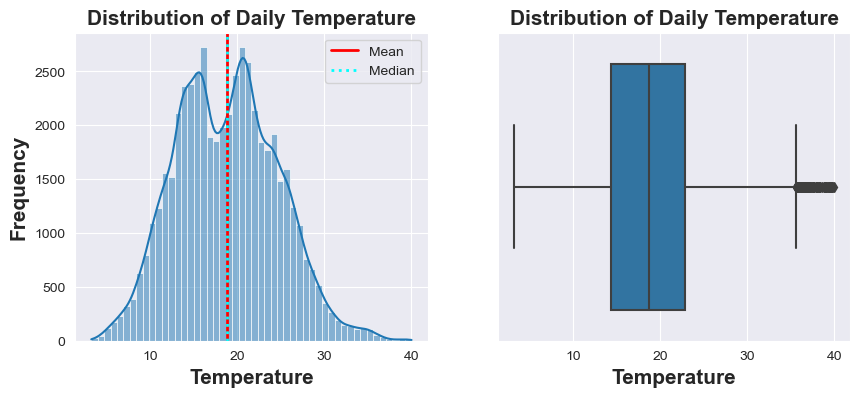

In [6]:
# Temperature distribution
plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_, 'temperature', 'Distribution of Daily Temperature', 'Temperature', 'Frequency', 50, True)

plt.subplot(1, 2, 2)
box_plot(data_,'temperature', 'Distribution of Daily Temperature', 'Temperature')

**The temperature distibution has a bi-modal distribution (Histogram plot) with two peaks at 15 and 20 respectively, with the mean and median values almost aligning at the same value. There are outlier values observable from the box plot occuring at temperature values above 35.**

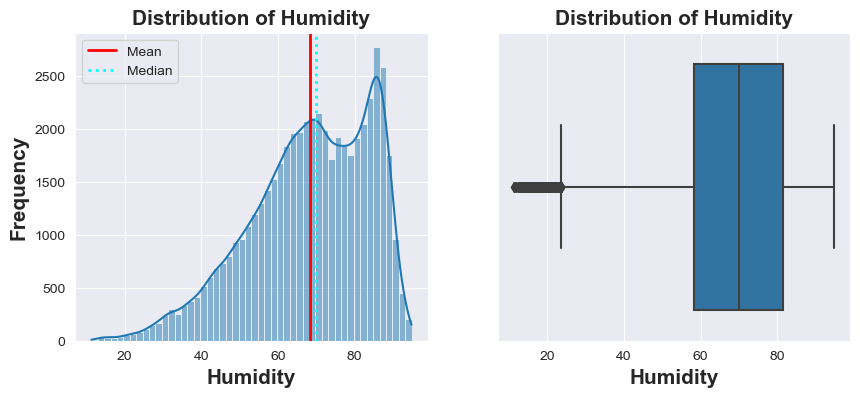

In [7]:
# Humidity distribution
plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_, 'humidity', 'Distribution of Humidity', 'Humidity', 'Frequency', 50, True)

plt.subplot(1, 2, 2)
box_plot(data_,'humidity', 'Distribution of Humidity', 'Humidity')

**The humidity distribution also shows bi-modal charatceristics with two peaks at about 70 and 85 respectively. The distribution is also left skewed as it tails towards the left, showing outlier values confirmed by the boxplot. This gives the idea that the daily hunidity have more higer values.**

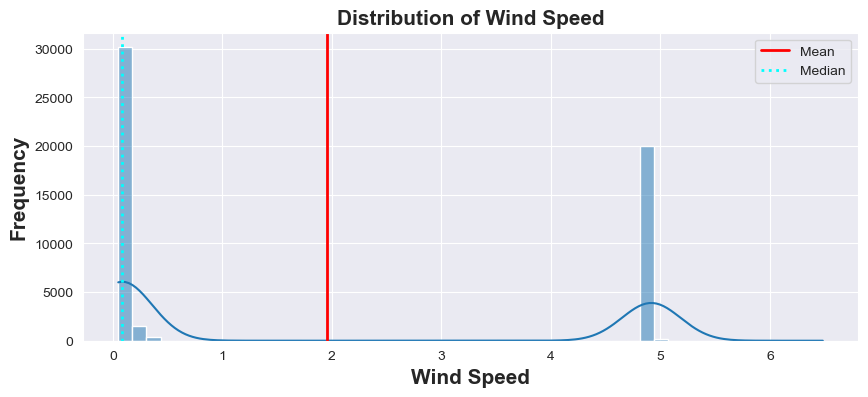

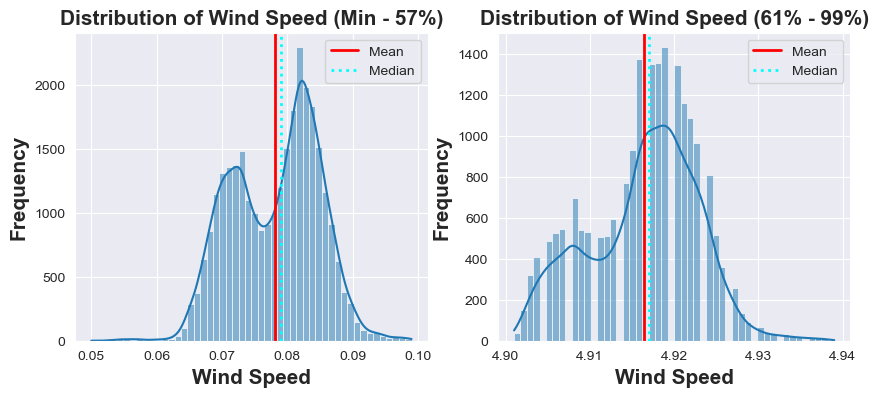

In [8]:
# Wind speed distribution
plt.figure(figsize = [10, 4])
hist_plot(data_, 'wind_speed', 'Distribution of Wind Speed', 'Wind Speed', 'Frequency', 50, True)

# Removing outlier values from wind speed
# Minimum value to 57%
lower_bound = data_['wind_speed'].quantile(0)
upper_bound = data_['wind_speed'].quantile(0.57)
mask_speed = data_['wind_speed'].between(lower_bound, upper_bound)
data_speed = data_[mask_speed]

plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_speed, 'wind_speed', 'Distribution of Wind Speed (Min - 57%)', 'Wind Speed', 'Frequency', 50, True)

# 61% to 99%
lower_bound = data_['wind_speed'].quantile(0.615)
upper_bound = data_['wind_speed'].quantile(0.997)
mask_speed = data_['wind_speed'].between(lower_bound, upper_bound)
data_speed = data_[mask_speed]

plt.subplot(1, 2, 2)
hist_plot(data_speed, 'wind_speed', 'Distribution of Wind Speed (61% - 99%)', 'Wind Speed', 'Frequency', 50, True)

**The first histogram confirms our earlier assertion about having extreme outlier values in the wind_speed. Diving deeper into the wind_speed column, it was observed that majority of the data lies between values 0.05 to 0.10, and 4.90 to 4.94, as can be seen in the plots above. 57% of the dataset lies between the minimum value (0.05) and 0.10, 37% lies between 4.90 to 4.94. The remaining 5% of the data lies between 0.10 to 4.90 and above 4.94, which contains the extreme outlier values.** 

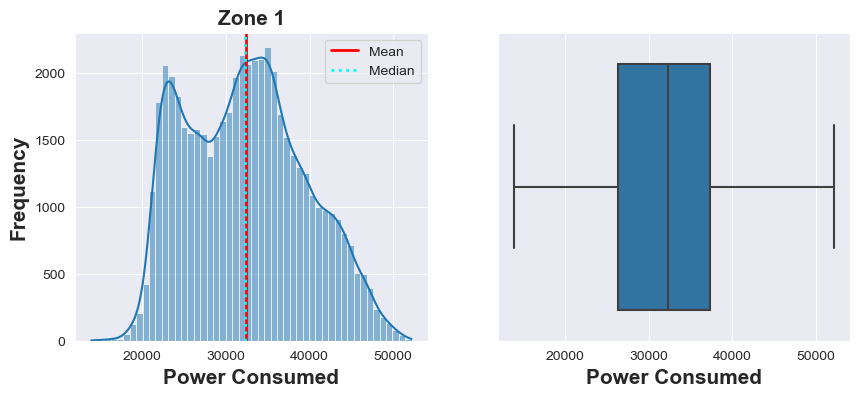

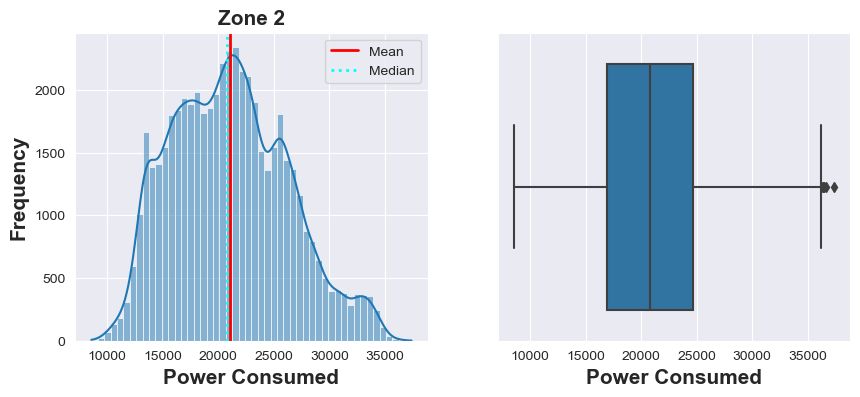

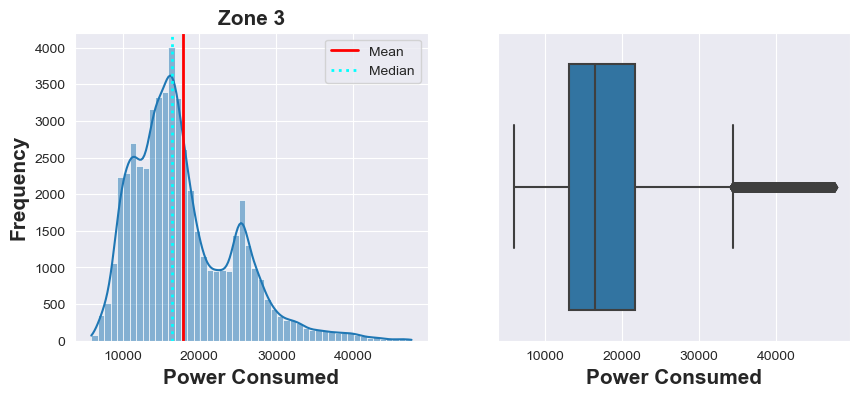

In [9]:
# Distribution of Power consumption in Zones 1, 2 and 3
#Zone 1
plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_, 'power_consumption_zone_1', 'Zone 1', 'Power Consumed', 'Frequency', 50, True)
plt.subplot(1, 2, 2)
box_plot(data_,'power_consumption_zone_1', '', 'Power Consumed')

#Zone 2
plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_, 'power_consumption_zone_2', 'Zone 2', 'Power Consumed', 'Frequency', 50, True)
plt.subplot(1, 2, 2)
box_plot(data_,'power_consumption_zone_2', '', 'Power Consumed')

# Zone 3
plt.figure(figsize = [10, 4])
plt.subplot(1, 2, 1)
hist_plot(data_, 'power_consumption_zone_3', 'Zone 3', 'Power Consumed', 'Frequency', 50, True)
plt.subplot(1, 2, 2)
box_plot(data_,'power_consumption_zone_3', '', 'Power Consumed')

- **Zone 1 power consumption has a bi-modal distribution with first peak between 20,000 to 25,000 and the second peak between 32,000 to 38,000. The mean and median values appear to be close as evident in the descriptive statistics performed earlier. The boxplot shows no outlier values.**
- **Zone 2 power distribution has multiple peak points with the most prominnt appearing between 20,000 and 25,000. The boxplot also shows outlier values towards the maximum values, which confirms why the mean value is slightly towards the right in the histogram.**
- **Zone 3 has a unimodal ditribution with peaks at about 18,000 and 28,000. The plot is right skewed showing the existence of outlier values, confirmed by the boxplot and the mean value moving away from the median.**

## Relationship between Zonal Power Consumption and select features

Zone 1 correlation values


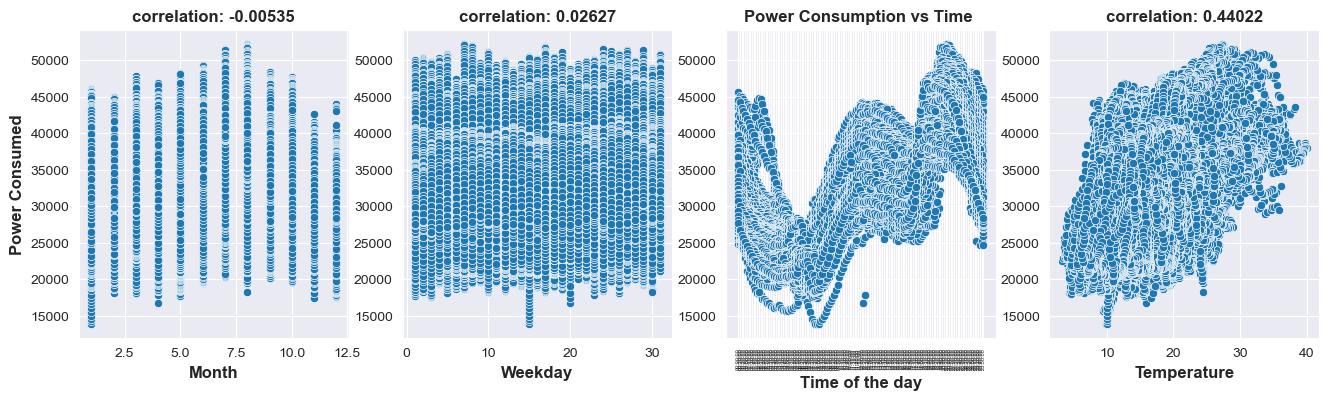

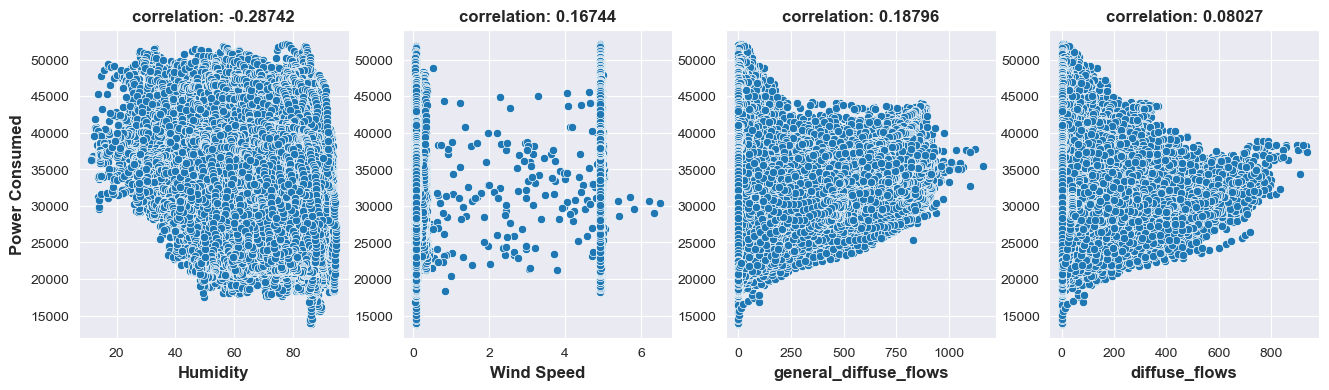

Zone 2 correlation values


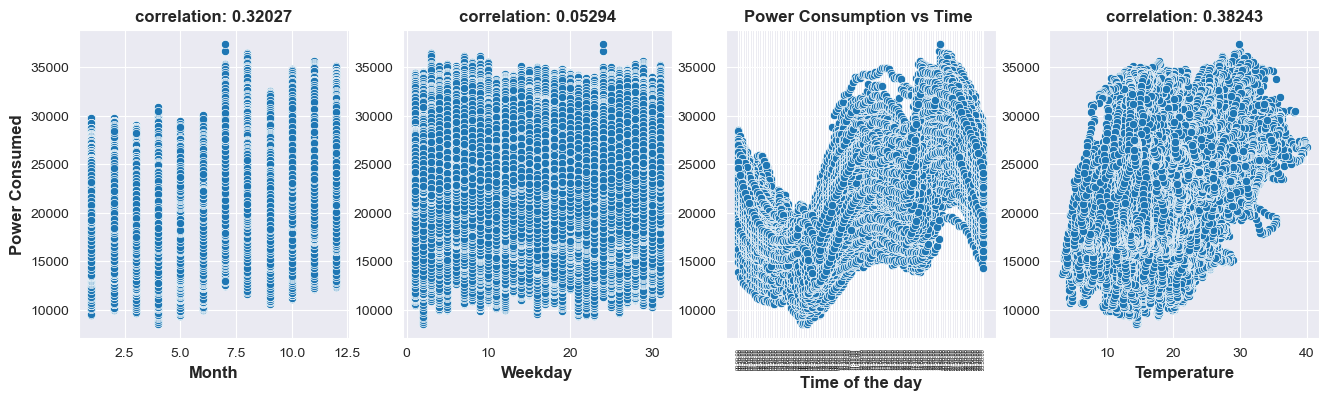

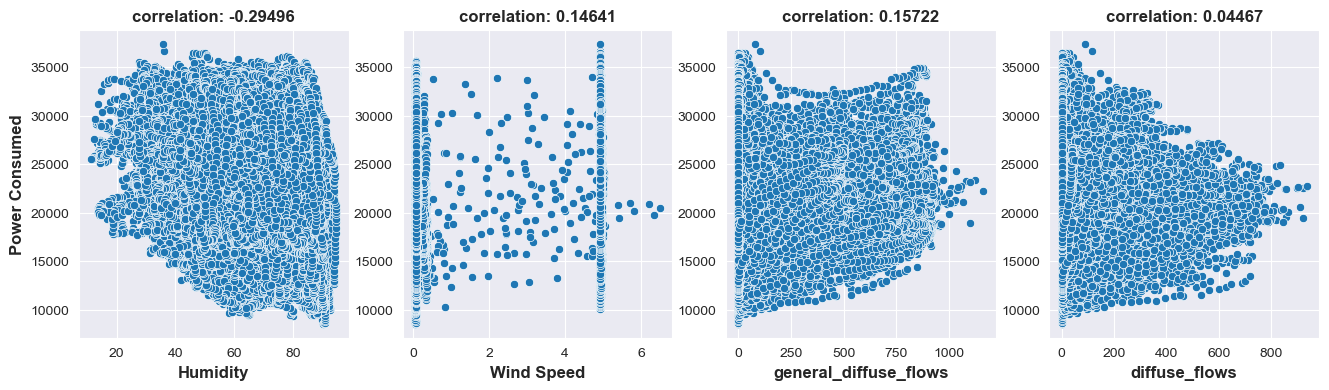

Zone 3 correlation values


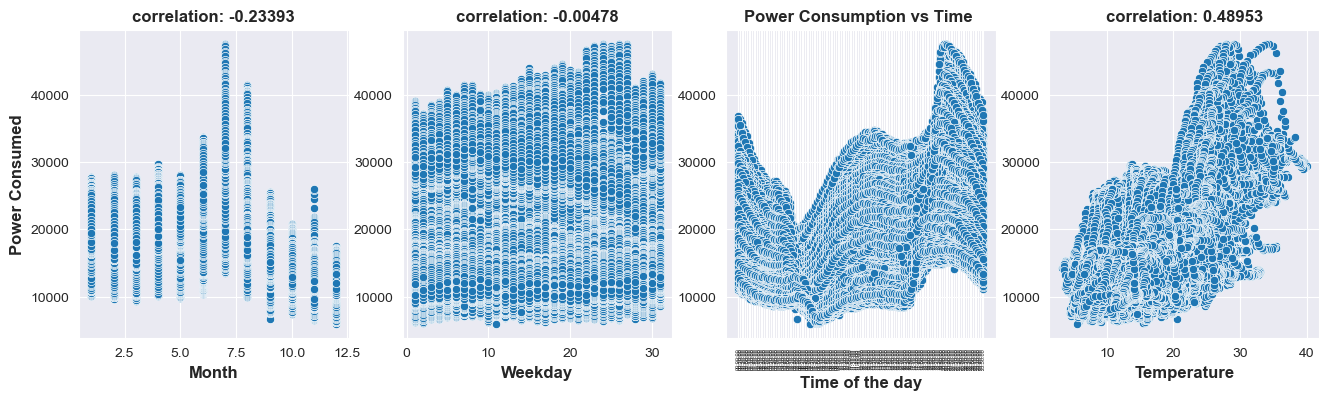

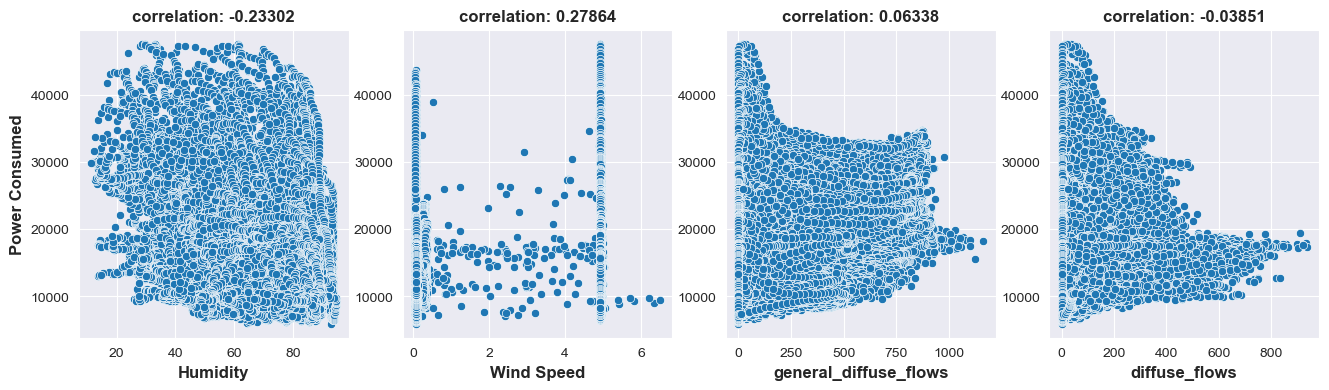

In [10]:
for num in range(1, 4):
    # Month
    print(f'Zone {num} correlation values')
    plt.figure(figsize = [16, 4])
    plt.subplot(1, 4, 1)
    scatter_plot(data_, 'month', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['month']).round(5)}",
                 'Month', 'Power Consumed')
    # Weekday
    plt.subplot(1, 4, 2)
    scatter_plot(data_, 'weekday', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['weekday']).round(5)}",
                 'Weekday', '')

    # Time
    plt.subplot(1, 4, 3)
    scatter_plot(data_, 'time', f'power_consumption_zone_{num}', f"Power Consumption vs Time ",'Time of the day', '')
    plt.xticks(size = 4, rotation = 90)

    # Temperature
    plt.subplot(1, 4, 4)
    scatter_plot(data_, 'temperature', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['temperature']).round(5)}",
                 'Temperature', '')

    # Humidity
    plt.figure(figsize = [16, 4])
    plt.subplot(1, 4, 1)
    scatter_plot(data_, 'humidity', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['humidity']).round(5)}",
                 'Humidity', 'Power Consumed')
    # Wind Speed
    plt.subplot(1, 4, 2)
    scatter_plot(data_, 'wind_speed', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['wind_speed']).round(5)}",
                 'Wind Speed', '')

    # General diffuse flows
    plt.subplot(1, 4, 3)
    scatter_plot(data_, 'general_diffuse_flows', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['general_diffuse_flows']).round(5)}",
                 'general_diffuse_flows', '')

    # Diffuse flows
    plt.subplot(1, 4, 4)
    scatter_plot(data_, 'diffuse_flows', f'power_consumption_zone_{num}',
                 f"correlation: {data_[f'power_consumption_zone_{num}'].corr(data_['diffuse_flows']).round(5)}",
                 'diffuse_flows', '')
    plt.show()

## Separate labels, features, split data

In [22]:
# Separate labels
features = ['month', 'weekday', 'temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows',  'time']
#features = data_.columns[:8]
zone_1 = data_.columns[-3]
zone_2 = data_.columns[-2]
zone_3 = data_.columns[-1]

# Split data into training and test set
X, y_1, y_2, y_3 = data_[features].values, data_[zone_1].values, data_[zone_2].values, data_[zone_3].values

# Split data into training and testing set
X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test, y_3_train, y_3_test, = train_test_split(X, y_1, y_2, y_3,
                                                                                                   test_size = 0.30,
                                                                                                   random_state = 0)
print(f'Trainig set: {X_train.shape[0]}\nTest set: {X_test.shape[0]}')

Trainig set: 36691
Test set: 15725


## Data Preprocessing

In [26]:
#Transform numeric columns and create pipeline
transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_feature = [7]
numeric_features = [0, 1, 2, 3, 4, 5, 6]
encode_time = OneHotEncoder(cols = categorical_feature, use_cat_names = True).fit(X_train).transform(X_train)
preprocess_data = ColumnTransformer(transformers = [('num', transformer, numeric_features)])

## Build Models
### Zone 1

In [27]:
# Random forest
zone_1_RF = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          RandomForestRegressor())
zone_1_RF.fit(X_train, y_1_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('randomforestregressor', RandomForestRegressor())])

In [28]:
# Gradient Boosting
zone_1_GB = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          GradientBoostingRegressor())
zone_1_GB.fit(X_train, y_1_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

### Zone 2

In [29]:
# Random Forest
zone_2_RF = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          RandomForestRegressor())
zone_2_RF.fit(X_train, y_2_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('randomforestregressor', RandomForestRegressor())])

In [30]:
# Gradient Boosting
zone_2_GB = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          GradientBoostingRegressor())
zone_2_GB.fit(X_train, y_2_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

### Zone 3

In [31]:
# Random Forest
zone_3_RF = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          RandomForestRegressor())
zone_3_RF.fit(X_train, y_3_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('randomforestregressor', RandomForestRegressor())])

In [32]:
# Gradient Boosting
zone_3_GB = make_pipeline(OneHotEncoder(cols = categorical_feature, use_cat_names = True), transformer, preprocess_data,
                          GradientBoostingRegressor())
zone_3_GB.fit(X_train, y_3_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[7], use_cat_names=True)),
                ('pipeline', Pipeline(steps=[('scaler', StandardScaler())])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

## Evaluate Models

In [33]:
# Make predictions and evaluate metrics
# Zone 1
zone_1_RF_predictions = zone_1_RF.predict(X_test)
zone_1_GB_predictions = zone_1_GB.predict(X_test)

# Zone 2
zone_2_RF_predictions = zone_2_RF.predict(X_test)
zone_2_GB_predictions = zone_2_GB.predict(X_test)

# Zone 3
zone_3_RF_predictions = zone_3_RF.predict(X_test)
zone_3_GB_predictions = zone_3_GB.predict(X_test)

# Get evaluation metrics
# Zone 1
z1_RF_mse = mean_squared_error(y_1_test, zone_1_RF_predictions)
z1_RF_rmse = np.sqrt(z1_RF_mse)
z1_RF_r2 = r2_score(y_1_test, zone_1_RF_predictions)
print(f'Zone 1\nRandom Forest Regression results:\nMSE: {z1_RF_mse}\nRMSE: {z1_RF_rmse}\nR2_SCORE: {z1_RF_r2}\n')

z1_GB_mse = mean_squared_error(y_1_test, zone_1_GB_predictions)
z1_GB_rmse = np.sqrt(z1_GB_mse)
z1_GB_r2 = r2_score(y_1_test, zone_1_GB_predictions)
print(f'Gradient Boosting Regression results:\nMSE: {z1_GB_mse}\nRMSE: {z1_GB_rmse}\nR2_SCORE: {z1_GB_r2}\n\n')

# Zone 2
z2_RF_mse = mean_squared_error(y_2_test, zone_2_RF_predictions)
z2_RF_rmse = np.sqrt(z2_RF_mse)
z2_RF_r2 = r2_score(y_2_test, zone_2_RF_predictions)
print(f'Zone 2\nRandom Forest Regression results:\nMSE: {z2_RF_mse}\nRMSE: {z2_RF_rmse}\nR2_SCORE: {z2_RF_r2}\n')

z2_GB_mse = mean_squared_error(y_2_test, zone_2_GB_predictions)
z2_GB_rmse = np.sqrt(z2_GB_mse)
z2_GB_r2 = r2_score(y_2_test, zone_2_GB_predictions)
print(f'Gradient Boosting Regression results:\nMSE: {z2_GB_mse}\nRMSE: {z2_GB_rmse}\nR2_SCORE: {z2_GB_r2}\n\n')

# Zone 3
z3_RF_mse = mean_squared_error(y_3_test, zone_3_RF_predictions)
z3_RF_rmse = np.sqrt(z3_RF_mse)
z3_RF_r2 = r2_score(y_3_test, zone_3_RF_predictions)
print(f'Zone 3\nRandom Forest Regression results:\nMSE: {z3_RF_mse}\nRMSE: {z3_RF_rmse}\nR2_SCORE: {z3_RF_r2}\n')

z3_GB_mse = mean_squared_error(y_3_test, zone_3_GB_predictions)
z3_GB_rmse = np.sqrt(z3_GB_mse)
z3_GB_r2 = r2_score(y_3_test, zone_3_GB_predictions)
print(f'Gradient Boosting Regression results:\nMSE: {z3_GB_mse}\nRMSE: {z3_GB_rmse}\nR2_SCORE: {z3_GB_r2}')

Zone 1
Random Forest Regression results:
MSE: 8968336.963824095
RMSE: 2994.718177696208
R2_SCORE: 0.823075007359499

Gradient Boosting Regression results:
MSE: 30897541.107802853
RMSE: 5558.555667419627
R2_SCORE: 0.3904614361438241


Zone 2
Random Forest Regression results:
MSE: 3968875.6474563167
RMSE: 1992.2037163544085
R2_SCORE: 0.852303845757979

Gradient Boosting Regression results:
MSE: 14872568.807129053
RMSE: 3856.496960601558
R2_SCORE: 0.44653816051892825


Zone 3
Random Forest Regression results:
MSE: 3903295.1561592687
RMSE: 1975.6758732543324
R2_SCORE: 0.91163259341864

Gradient Boosting Regression results:
MSE: 13002012.22139147
RMSE: 3605.83030956692
R2_SCORE: 0.7056450884759509
